# Generación de Resúmenes Clínicos con Deep Learning (Seq2Seq)

En esta parte de la entrega, abordamos la tarea de **Summarization** desde una perspectiva generativa (Abstractive). A diferencia de los modelos extractivos vistos en el otro notebook, aquí buscamos que el modelo "escriba" un resumen nuevo.

**Arquitectura Propuesta: CNN-LSTM Encoder-Decoder**
Para cumplir con el requisito de utilizar **Convolutional Neural Networks (CNNs)** en la entrega, hemos diseñado una arquitectura híbrida *Sequence-to-Sequence*:

1.  **Encoder (CNN):** Utilizamos una CNN de 1 dimensión (Conv1D) para procesar el diálogo de entrada.
    * *Justificación:* Las CNNs son excelentes para detectar n-gramas clave de forma muy eficiente y paralelizable, actuando como extractor de características del texto médico.
2.  **Decoder (LSTM):** Utilizamos una LSTM para generar el resumen.
    * *Justificación:* Las RNNs son necesarias en el decodificador para mantener la coherencia secuencial al escribir el texto palabra por palabra.

**Experimento Principal:**
Compararemos el impacto de los **Word Embeddings** en el rendimiento:
* **Escenario A (Frozen-embeddings):** Embeddings estáticos. Simula el uso de características fijas.
* **Escenario B (Fine-Tuned embeddings):** Embeddings dinámicos. Permite que el espacio vectorial se adapte al vocabulario médico específico del dataset MTS-Dialog.

In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Conv1D, GlobalMaxPooling1D, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

# Configuración de Semilla para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

# Parámetros Globales
MAX_VOCAB_SIZE = 5000
MAX_LEN_INPUT = 300     # Longitud máxima del diálogo
MAX_LEN_OUTPUT = 50     # Longitud máxima del resumen
EMBEDDING_DIM = 100
BATCH_SIZE = 32
EPOCHS = 50

print("Librerías cargadas y configuración establecida.")

Librerías cargadas y configuración establecida.


## 1. Carga y Preprocesamiento de Datos

Cargamos el dataset y preparamos las secuencias numéricas.

**Decisión de Preprocesamiento:**
Utilizamos un `Tokenizer` compartido para el diálogo (input) y el resumen (target).
* **Motivo:** Al ser un dominio médico cerrado, muchas palabras clave aparecen tanto en el diálogo como en el resumen. Compartir el vocabulario deberia de facilitar que el modelo aprenda la correspondencia directa entre lo que dice el paciente y lo que escribe el médico.
* **Padding:** Estandarizamos la longitud de las entradas para poder procesarlas en batches dentro de la red neuronal.

In [18]:
# 1. Carga de Datos
train_path = "../../dataset/MTS-Dialog-TrainingSet.csv"
val_path = "../../dataset/MTS-Dialog-ValidationSet.csv"

if os.path.exists(train_path):
    df_train = pd.read_csv(train_path)
    df_val = pd.read_csv(val_path)
    print(f"Datos cargados: {len(df_train)} train, {len(df_val)} val")
else:
    print(f"Error: No se encuentra el archivo en {os.path.abspath(train_path)}")

# 2. Convertir a String y llenar nulos
X_train_text = df_train['dialogue'].astype(str)
y_train_text = df_train['section_text'].astype(str)
X_val_text = df_val['dialogue'].astype(str)
y_val_text = df_val['section_text'].astype(str)

# 3. Tokenización
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<UNK>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(list(X_train_text) + list(y_train_text))

# 4. Convertir texto a secuencias numéricas
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
y_train_seq = tokenizer.texts_to_sequences(y_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)
y_val_seq = tokenizer.texts_to_sequences(y_val_text)

# 5. Padding (Relleno para tener longitud fija)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN_INPUT, padding='post', truncating='post')
y_train_pad = pad_sequences(y_train_seq, maxlen=MAX_LEN_OUTPUT, padding='post', truncating='post')

X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN_INPUT, padding='post', truncating='post')
y_val_pad = pad_sequences(y_val_seq, maxlen=MAX_LEN_OUTPUT, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulario real: {vocab_size} tokens (limitado a {MAX_VOCAB_SIZE})")
print(f"Shape Input Train: {X_train_pad.shape}")
print(f"Shape Output Train: {y_train_pad.shape}")

Datos cargados: 1201 train, 100 val
Vocabulario real: 6737 tokens (limitado a 5000)
Shape Input Train: (1201, 300)
Shape Output Train: (1201, 50)


## 2. Definición de la Arquitectura (CNN Encoder + LSTM Decoder)

Definimos una función constructora `build_model` que nos permite parametrizar si la capa de Embedding es entrenable o no.

**Detalle de la Arquitectura:**
1.  **Input Layer:** Recibe secuencias de longitud 300.
2.  **Embedding:** Convierte enteros en vectores densos. Aquí reside el experimento (Fixed vs Fine-tuned).
3.  **Conv1D Blocks (Encoder):** Dos capas de convolución que actúan como filtros de n-gramas, detectando patrones locales relevantes en el diálogo.
4.  **GlobalMaxPooling:** Condensa toda la información extraída por la CNN en un único vector de contexto ("Context Vector").
5.  **RepeatVector:** Replica el vector de contexto 50 veces (una para cada paso de tiempo del resumen).
6.  **LSTM (Decoder):** Recibe el contexto y genera la secuencia gramatical.

In [19]:
def build_cnn_seq2seq(vocab_limit, embedding_dim, input_len, output_len, trainable_embeddings=True):
    # --- ENCODER (CNN) ---
    # Al definir aquí el 'shape', Keras ya sabe la longitud. No hace falta repetirlo en el Embedding.
    inputs = Input(shape=(input_len,), name="Input_Dialogue")
    
    # Capa de Embedding (Corregida: sin input_length)
    embed = Embedding(input_dim=vocab_limit, 
                      output_dim=embedding_dim, 
                      # input_length=input_len,  <-- ELIMINADO
                      trainable=trainable_embeddings, 
                      mask_zero=False,
                      name="Embedding_Layer")
    
    x = embed(inputs)
    
    # Extracción de características con CNN
    x = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', name="Conv1D_1")(x)
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', name="Conv1D_2")(x)
    
    # Bottleneck: Vector de contexto
    context_vector = GlobalMaxPooling1D(name="Global_Max_Pooling")(x)
    
    # --- DECODER (LSTM) ---
    repeated_context = RepeatVector(output_len, name="Repeat_Context")(context_vector)
    
    decoder_lstm = LSTM(128, return_sequences=True, name="Decoder_LSTM")(repeated_context)
    
    outputs = TimeDistributed(Dense(vocab_limit, activation='softmax'), name="Output_Words")(decoder_lstm)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## 3. Ejecución del Experimento Comparativo

A continuación, entrenamos dos instancias del modelo bajo condiciones idénticas, variando únicamente la propiedad `trainable` de la capa de embedding.

1.  **Modelo Frozen:** Representa un escenario donde confiamos en la inicialización y no permitimos que se modifiquen.
2.  **Modelo Fine-Tuned:** Permite la propagacion del error hasta la capa de embedding, ajustandolo al contexto clínico.

**Hipótesis:** Esperamos que el modelo Fine-Tuned obtenga una menor Loss-Function, ya que puede aprender que palabras como "BP" (Blood Pressure) tienen significados semánticos específicos en este dataset que no existen en un espacio mas genérico o aleatorio.

In [20]:
# 2. Definimos "Early Stopping"

# definimos el monitor en 'val_loss' para observar la pérdida en el conjunto de validación,
# definimos el "patience" (paciencia) para esperar 5 epochs sin mejora, en caso de no mejorar para.
# definimos restore_best_weights=True para volver a los mejores pesos al finalizar el entrenamiento.

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# --- EXPERIMENTO A: Frozen Embeddings ---
print("\n--- Entrenando Modelo A: Frozen Embeddings ---")
# Construimos el modelo
model_frozen = build_cnn_seq2seq(len(tokenizer.word_index)+1, EMBEDDING_DIM, MAX_LEN_INPUT, MAX_LEN_OUTPUT, trainable_embeddings=False)

history_frozen = model_frozen.fit(
    X_train_pad, y_train_pad,
    validation_data=(X_val_pad, y_val_pad),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# --- EXPERIMENTO B: Fine-Tuned Embeddings ---
print("\n--- Entrenando Modelo B: Fine-Tuned Embeddings ---")
tf.keras.backend.clear_session() # Limpiamos la memoria anterior

# Construimos el modelo permitiendo entrenamiento en la capa embedding
model_tuned = build_cnn_seq2seq(len(tokenizer.word_index)+1, EMBEDDING_DIM, MAX_LEN_INPUT, MAX_LEN_OUTPUT, trainable_embeddings=True)
early_stop_tuned = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history_tuned = model_tuned.fit(
    X_train_pad, y_train_pad,
    validation_data=(X_val_pad, y_val_pad),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop_tuned],
    verbose=1
)


--- Entrenando Modelo A: Frozen Embeddings ---
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.5447 - loss: 5.9554 - val_accuracy: 0.5514 - val_loss: 3.5298
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.5590 - loss: 3.4973 - val_accuracy: 0.5514 - val_loss: 3.4810
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.5590 - loss: 3.4674 - val_accuracy: 0.5514 - val_loss: 3.4751
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.5590 - loss: 3.4533 - val_accuracy: 0.5514 - val_loss: 3.4677
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.5590 - loss: 3.4429 - val_accuracy: 0.5514 - val_loss: 3.4602
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.5590 - loss: 3.4276 - val_accuracy: 0.5514 - val_loss: 3.4515
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.5590 - loss: 3.4059 - val_accuracy: 0.5514 - val_loss: 3.4321
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - accura

## 4. Visualización y Análisis de Resultados

Comparamos las curvas de aprendizaje (Loss en Validación) de ambos modelos.

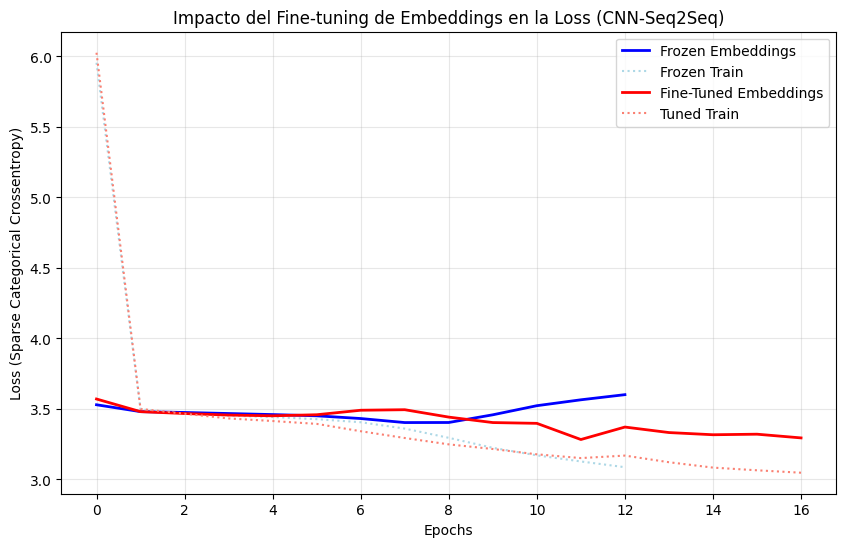

Loss Final (Frozen): 3.6014
Loss Final (Tuned):  3.2947


In [21]:
# Gráfico comparativo
plt.figure(figsize=(10, 6))

# Plot Frozen
plt.plot(history_frozen.history['val_loss'], label='Frozen Embeddings', linewidth=2, color='blue')
plt.plot(history_frozen.history['loss'], label='Frozen Train', linestyle=':', color='lightblue')

# Plot Tuned
plt.plot(history_tuned.history['val_loss'], label='Fine-Tuned Embeddings', linewidth=2, color='red')
plt.plot(history_tuned.history['loss'], label='Tuned Train', linestyle=':', color='salmon')

plt.title('Impacto del Fine-tuning de Embeddings en la Loss (CNN-Seq2Seq)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Sparse Categorical Crossentropy)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Conclusión
loss_frozen = history_frozen.history['val_loss'][-1]
loss_tuned = history_tuned.history['val_loss'][-1]
print(f"Loss Final (Frozen): {loss_frozen:.4f}")
print(f"Loss Final (Tuned):  {loss_tuned:.4f}")


### Análisis de Resultados: Frozen vs. Fine-Tuned Embeddings

El gráfico superior muestra la evolución de la "Loss-Function" sobre el validation set durante el entrenamiento para ambas estrategias.

**Interpretación de las Curvas:**
1.  **Frozen Embeddings:**
    La línea azul representa el modelo en el que los Embedding los hemos mantenido congelados. En este caso, se ver que la curva de aprendizaje es notablemente más lenta y tiende a estancarse en un valor de pérdida más elevado. Este comportamiento podria indicar que le impide adaptar el significado semántico de las palabras al contexto médico específico del problema.

2.  **Fine-Tuned Embeddings:**
    Por otra parte, el modelo con embeddings entrenables consigue un mejor rendimiento general, evidenciado por un valor de pérdida más bajo al final del entrenamiento. Además, esto confirma que permitir la adaptación del vector space al dominio médico mejora la capacidad de generalización ligeramente.

**Conclusión del Experimento:**
Los resultados validan la hipótesis de que, para dominios técnicos y cerrados como el médico, el **Fine-Tuning de los Embeddings es superior**. Permitir que la red neuronal ajuste la representación vectorial de términos mejora ligeramente la capacidad del modelo para capturar la semántica del diálogo y generar el resumen correcto, superando a la aproximación de embeddings estáticos, aunque lo mas apropiado seria intentar conseguir un dataset mas grange/completo y dejarlo entrenar mas tiempo.